In [38]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

import lightgbm as lgb
from lightgbm import LGBMClassifier

import optuna

In [2]:
N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TARGET_NAME = 'TARGET' # Target column name

In [3]:
DATASET_DIR = './test_data_files'
DATASET_NAME = 'sampled_app_train.csv'
DATASET_FULLNAME = os.path.join(DATASET_DIR, DATASET_NAME)

In [4]:
data = pd.read_csv(DATASET_FULLNAME)
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 9.3+ MB


In [6]:
data['BIRTH_DATE'] = (np.datetime64('2018-01-01') + data['DAYS_BIRTH'].astype(np.dtype('timedelta64[D]'))).astype(str)
data['EMP_DATE'] = (np.datetime64('2018-01-01') + np.clip(data['DAYS_EMPLOYED'], None, 0).astype(np.dtype('timedelta64[D]'))
                    ).astype(str)

data['constant'] = 1
data['allnan'] = np.nan

data['report_dt'] = np.datetime64('2018-01-01')

data.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], axis=1, inplace=True)

![AutoML pipeline for this task](tutorial_1_pipeline.png)

### SimpleFeatures for TreeBasedModel

- Numeric stay as is, Datetime transforms to numeric.
- Categorical label encoding.
- Maps input to output features exactly one-to-one.

In [7]:
numerical_columns = data._get_numeric_data().columns
date_columns = ['BIRTH_DATE', 'EMP_DATE']
categorycal_columns = list(set(data.columns) - set(numerical_columns) - set(date_columns))

In [8]:
df = data.copy()

In [9]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,2018-01-01
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,2018-01-01
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,2018-01-01
3,381593,0,Cash loans,F,N,N,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,2018-01-01
4,258153,0,Cash loans,F,Y,Y,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,2018-01-01


#### LavelEncoding

In [10]:
for cat_col in categorycal_columns:
    le = LabelEncoder()
    df[cat_col] = le.fit_transform(df[cat_col])

In [11]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,0,1,0,1,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,0
1,319656,0,0,0,0,0,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,0
2,207678,0,1,0,1,1,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,0
3,381593,0,0,0,0,0,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,0
4,258153,0,0,0,1,1,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,0


#### One-Hot-Encoding

In [10]:
for cat_col in categorycal_columns:
    le = OneHotEncoder(handle_unknown='error', drop='if_binary')
    a = le.fit_transform(df[[cat_col]]).toarray()
    shift = df.columns[-1]
    if not isinstance(shift, int):
        shift = 0
    end_col = pd.DataFrame(data=a, columns=np.arange(a.shape[1]) + shift + 1)
    df = df.join(end_col)
    df.drop(axis=1, inplace=True, columns=[cat_col])

In [175]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,313802,0,0,1,0,1,0,270000.0,327024.0,15372.0,...,0.0,0.0,0.0,0.0,1.0,1967-02-08,2017-05-20,1,NaN,0
1,319656,0,0,0,0,0,0,108000.0,675000.0,19737.0,...,0.0,0.0,0.0,0.0,0.0,1962-05-19,2007-07-16,1,NaN,0
2,207678,0,1,0,1,1,2,112500.0,270000.0,13500.0,...,0.0,0.0,0.0,0.0,1.0,1991-11-14,2015-01-21,1,NaN,0
3,381593,0,0,0,0,0,1,67500.0,142200.0,9630.0,...,0.0,0.0,0.0,0.0,4.0,1986-09-25,2011-10-13,1,NaN,0
4,258153,0,0,0,1,1,0,337500.0,1483231.5,46570.5,...,0.0,0.0,2.0,0.0,0.0,1981-11-08,2013-02-21,1,NaN,0


#### Datetime to numeric

In [12]:
basic_time = '2020-01-01'
basic_interval = 'D'

for date_col in date_columns:
    df[date_col] = pd.to_datetime(df[date_col])
    df[date_col] = ((df[date_col] - np.datetime64(basic_time)) / np.timedelta64(1, basic_interval)).values.astype(np.float32)

# ------------------------------

### ImportanceBasedFeatureSelector

In [13]:
train_labels = df['TARGET']
df.drop(columns=['TARGET'], axis=1, inplace=True)
train = df
num_feats = len(train.columns)

In [14]:
lgbc=LGBMClassifier(learning_rate=0.05, num_leaves=64)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(train, train_labels)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

29 selected features


In [15]:
df = df[embeded_lgb_feature]
df.head()

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,...,LIVINGAREA_AVG,BASEMENTAREA_MODE,COMMONAREA_MODE,LANDAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE
0,313802,270000.0,327024.0,15372.0,270000.0,0.072508,-2432.0,-2137,NaN,6,...,0.0672,0.0000,0.0248,0.0000,0.0686,0.0,-1275.0,1.0,-19320.0,-956.0
1,319656,108000.0,675000.0,19737.0,675000.0,0.035792,-13156.0,-3758,NaN,16,...,NaN,NaN,NaN,NaN,NaN,1.0,-1732.0,0.0,-21046.0,-4552.0
2,207678,112500.0,270000.0,13500.0,270000.0,0.031329,-4077.0,-1058,18.0,8,...,0.0023,NaN,NaN,NaN,0.0018,4.0,-1597.0,1.0,-10275.0,-1806.0
3,381593,67500.0,142200.0,9630.0,112500.0,0.008474,-5106.0,-1556,NaN,18,...,0.0337,0.0000,NaN,0.0212,0.0214,0.0,-1069.0,4.0,-12151.0,-3002.0
4,258153,337500.0,1483231.5,46570.5,1354500.0,0.008474,-5743.0,-4256,9.0,10,...,0.0863,0.0816,0.0121,0.0981,0.0753,0.0,-1104.0,0.0,-13933.0,-2505.0


#### First level models

In [16]:
train_features, test_features, train_target, test_target = train_test_split(df, train_labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_full_features, test_full_features = train_test_split(train, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_features

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,...,LIVINGAREA_AVG,BASEMENTAREA_MODE,COMMONAREA_MODE,LANDAREA_MODE,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE
9254,445173,162000.0,619254.0,29920.5,553500.0,0.018634,-11124.0,-1885,NaN,11,...,NaN,NaN,NaN,NaN,NaN,6.0,-1527.0,4.0,-12299.0,-1711.0
1561,120419,202500.0,805536.0,36531.0,720000.0,0.010147,-7349.0,-1977,NaN,10,...,0.0740,0.0567,0.0451,0.0167,0.0827,3.0,-281.0,2.0,-19199.0,-4915.0
1670,266087,157500.0,505332.0,35298.0,477000.0,0.018850,-9707.0,-2275,5.0,0,...,NaN,NaN,NaN,NaN,NaN,9.0,-2.0,1.0,-19446.0,-2813.0
6087,200021,202500.0,260640.0,27499.5,225000.0,0.031329,-5322.0,-3113,NaN,6,...,NaN,NaN,NaN,NaN,NaN,0.0,-1853.0,2.0,-11454.0,-3804.0
6669,120701,54000.0,269550.0,13891.5,225000.0,0.030755,-1524.0,-2197,NaN,6,...,NaN,NaN,NaN,NaN,NaN,0.0,-719.0,NaN,-19382.0,-1702.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,234579,162000.0,891072.0,35469.0,720000.0,0.007305,-10858.0,-4592,NaN,18,...,0.2433,0.1165,0.0387,0.1262,0.2273,0.0,-1409.0,NaN,-23418.0,-730.0
5191,418107,180000.0,243000.0,23800.5,243000.0,0.020246,-6677.0,-4472,11.0,3,...,NaN,NaN,NaN,NaN,NaN,1.0,-1835.0,4.0,-16790.0,-8458.0
5390,296083,247500.0,360000.0,28440.0,360000.0,0.035792,-1632.0,-2009,16.0,10,...,NaN,NaN,NaN,NaN,NaN,0.0,-1103.0,3.0,-19193.0,-1856.0
860,103189,225000.0,277969.5,15957.0,229500.0,0.008230,-7772.0,-4929,NaN,4,...,NaN,NaN,NaN,NaN,NaN,1.0,-254.0,2.0,-15925.0,-1194.0


In [67]:
default_params = {
    'task': 'train',
    "learning_rate": 0.01,
    "num_leaves": 24,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    'bagging_freq': 1,
    "max_depth": -1,
    "verbosity": -1,
    "reg_alpha": 0.5,
    "reg_lambda": 0.0,
    "min_split_gain": 0.0,
    'zero_as_missing': False,
    'num_threads': 4,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'num_trees': 3000,
    'random_state': 42,
    'early_stopping_rounds': 200
}
# **default_params
lgbc=LGBMClassifier(**default_params)
lgbc.fit(train_features, train_target, eval_set=(test_features, test_target), eval_metric = 'auc')
LGBM_predicted_train = lgbc.predict_proba(train_features)
LGBM_predicted_test = lgbc.predict_proba(test_features)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.697715	valid_0's binary_logloss: 0.260229
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.695992	valid_0's binary_logloss: 0.259885
[3]	valid_0's auc: 0.705047	valid_0's binary_logloss: 0.259496
[4]	valid_0's auc: 0.705352	valid_0's binary_logloss: 0.259171
[5]	valid_0's auc: 0.70759	valid_0's binary_logloss: 0.258739
[6]	valid_0's auc: 0.705668	valid_0's binary_logloss: 0.258372
[7]	valid_0's auc: 0.71668	valid_0's binary_logloss: 0.258032
[8]	valid_0's auc: 0.710955	valid_0's binary_logloss: 0.257901
[9]	valid_0's auc: 0.710098	valid_0's binary_logloss: 0.257654
[10]	valid_0's auc: 0.715516	valid_0's binary_logloss: 0.257182
[11]	valid_0's auc: 0.71657	valid_0's binary_logloss: 0.256949
[12]	valid_0's auc: 0.71858	valid_0's binary_logloss: 0.256549
[13]	valid_0's auc: 0.71787	valid_0's binary_logloss: 0.256254
[14]	valid_0's auc: 0.720829	valid_0's binary_logloss: 0.255853
[15]	valid_0's auc: 0.718624	valid_0's binary_logloss: 0

In [61]:
def objective(trial):
    
    train_fea, valid_fea, train_tar, valid_tar = train_test_split(train_features, train_target, test_size=0.2, random_state=42)
    
    dtrain = lgb.Dataset(train_fea, label = train_tar, free_raw_data = False)
    dtest  = lgb.Dataset(valid_fea, label = valid_tar, free_raw_data = False)
    
    param = {
        'task': 'train',
        "learning_rate": 0.01,
        'bagging_freq': 1,
        "max_depth": -1,
        "verbosity": -1,
        "reg_alpha": 0.5,
        "reg_lambda": 0.0,
        "min_split_gain": 0.0,
        'zero_as_missing': False,
        'num_threads': 4,
        'max_bin': 255,
        'min_data_in_bin': 3,
        'num_trees': 3000,
        'random_state': 42,
        'early_stopping_rounds': 200,
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'metric': 'auc',
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-3, 10.0)
    }
    
    # Add a callback for pruning
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc')
    
    gbm = lgb.train(
        param, 
        dtrain, 
        verbose_eval = 20,
        valid_sets = [dtest],
        callbacks = [pruning_callback]
        )
    
    preds = gbm.predict(test_features)
#     accuracy = np.sqrt(mean_squared_error(test_target, preds))
    accuracy = roc_auc_score(test_target, preds)

    return accuracy



study = optuna.create_study(direction = 'maximize', pruner = optuna.pruners.MedianPruner(n_warmup_steps = 10))
study.optimize(objective, n_trials = 100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    

[I 2021-07-15 12:45:03,375] A new study created in memory with name: no-name-63b21442-481b-44e4-ac2e-7db7ba5dfe10


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.728869
[40]	valid_0's auc: 0.73903
[60]	valid_0's auc: 0.739819
[80]	valid_0's auc: 0.739753
[100]	valid_0's auc: 0.745352
[120]	valid_0's auc: 0.742415
[140]	valid_0's auc: 0.74576
[160]	valid_0's auc: 0.745968
[180]	valid_0's auc: 0.748254
[200]	valid_0's auc: 0.746376
[220]	valid_0's auc: 0.746691
[240]	valid_0's auc: 0.748188
[260]	valid_0's auc: 0.748005
[280]	valid_0's auc: 0.747516
[300]	valid_0's auc: 0.746696
[320]	valid_0's auc: 0.746661
[340]	valid_0's auc: 0.746447


[I 2021-07-15 12:45:05,066] Trial 0 finished with value: 0.6955627846454131 and parameters: {'num_leaves': 155, 'feature_fraction': 0.5082564710014214, 'bagging_fraction': 0.8357972279123371, 'min_sum_hessian_in_leaf': 0.3301242944375339}. Best is trial 0 with value: 0.6955627846454131.


[360]	valid_0's auc: 0.745805
Early stopping, best iteration is:
[178]	valid_0's auc: 0.748982
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.713384
[40]	valid_0's auc: 0.737706
[60]	valid_0's auc: 0.742181
[80]	valid_0's auc: 0.749618
[100]	valid_0's auc: 0.75058
[120]	valid_0's auc: 0.751777
[140]	valid_0's auc: 0.754454
[160]	valid_0's auc: 0.753227
[180]	valid_0's auc: 0.749557
[200]	valid_0's auc: 0.746885
[220]	valid_0's auc: 0.745576
[240]	valid_0's auc: 0.747689
[260]	valid_0's auc: 0.747246
[280]	valid_0's auc: 0.744762
[300]	valid_0's auc: 0.743184
[320]	valid_0's auc: 0.745383
[340]	valid_0's auc: 0.745133
Early stopping, best iteration is:
[142]	valid_0's auc: 0.754872


[I 2021-07-15 12:45:06,660] Trial 1 finished with value: 0.6981503857235802 and parameters: {'num_leaves': 233, 'feature_fraction': 0.8176278517531212, 'bagging_fraction': 0.6806283115679338, 'min_sum_hessian_in_leaf': 0.05159404575192025}. Best is trial 1 with value: 0.6981503857235802.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.738887
[40]	valid_0's auc: 0.745413
[60]	valid_0's auc: 0.744232
[80]	valid_0's auc: 0.753197
[100]	valid_0's auc: 0.752907
[120]	valid_0's auc: 0.756653
[140]	valid_0's auc: 0.756083
[160]	valid_0's auc: 0.757061
[180]	valid_0's auc: 0.755757
[200]	valid_0's auc: 0.755834
[220]	valid_0's auc: 0.753899
[240]	valid_0's auc: 0.754195
[260]	valid_0's auc: 0.753314
[280]	valid_0's auc: 0.754332


[I 2021-07-15 12:45:07,731] Trial 2 finished with value: 0.7221228738730365 and parameters: {'num_leaves': 56, 'feature_fraction': 0.8142303014948176, 'bagging_fraction': 0.5944839490450382, 'min_sum_hessian_in_leaf': 0.002022322179214184}. Best is trial 2 with value: 0.7221228738730365.


[300]	valid_0's auc: 0.755559
[320]	valid_0's auc: 0.755493
Early stopping, best iteration is:
[136]	valid_0's auc: 0.757992
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.729429
[40]	valid_0's auc: 0.731038
[60]	valid_0's auc: 0.7317
[80]	valid_0's auc: 0.738893
[100]	valid_0's auc: 0.739076
[120]	valid_0's auc: 0.739763
[140]	valid_0's auc: 0.74184
[160]	valid_0's auc: 0.745531
[180]	valid_0's auc: 0.744624
[200]	valid_0's auc: 0.74604
[220]	valid_0's auc: 0.745663
[240]	valid_0's auc: 0.743637
[260]	valid_0's auc: 0.743026
[280]	valid_0's auc: 0.743016
[300]	valid_0's auc: 0.744619
[320]	valid_0's auc: 0.744019
[340]	valid_0's auc: 0.741753
[360]	valid_0's auc: 0.741076
Early stopping, best iteration is:
[169]	valid_0's auc: 0.746762


[I 2021-07-15 12:45:10,073] Trial 3 finished with value: 0.6893354400966633 and parameters: {'num_leaves': 166, 'feature_fraction': 0.979648114977517, 'bagging_fraction': 0.8496143940012488, 'min_sum_hessian_in_leaf': 0.006445520997660723}. Best is trial 2 with value: 0.7221228738730365.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.72217
[40]	valid_0's auc: 0.733125
[60]	valid_0's auc: 0.735792
[80]	valid_0's auc: 0.737997
[100]	valid_0's auc: 0.740002
[120]	valid_0's auc: 0.74691
[140]	valid_0's auc: 0.747287
[160]	valid_0's auc: 0.749196
[180]	valid_0's auc: 0.747653
[200]	valid_0's auc: 0.746997
[220]	valid_0's auc: 0.746269
[240]	valid_0's auc: 0.74661
[260]	valid_0's auc: 0.742573
[280]	valid_0's auc: 0.742476
[300]	valid_0's auc: 0.741641
[320]	valid_0's auc: 0.740033


[I 2021-07-15 12:45:11,810] Trial 4 finished with value: 0.7109508318616973 and parameters: {'num_leaves': 144, 'feature_fraction': 0.8646047140228408, 'bagging_fraction': 0.6512633411079802, 'min_sum_hessian_in_leaf': 0.1188838190165687}. Best is trial 2 with value: 0.7221228738730365.


[340]	valid_0's auc: 0.738994
[360]	valid_0's auc: 0.738353
Early stopping, best iteration is:
[160]	valid_0's auc: 0.749196
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 12:45:11,869] Trial 5 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:11,936] Trial 6 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:11,997] Trial 7 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:12,074] Trial 8 pruned. Trial was pruned at iteration 11.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:12,141] Trial 9 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.741545
[40]	valid_0's auc: 0.750255
[60]	valid_0's auc: 0.752973
[80]	valid_0's auc: 0.754352
[100]	valid_0's auc: 0.753696
[120]	valid_0's auc: 0.757641
[140]	valid_0's auc: 0.758247
[160]	valid_0's auc: 0.758659
[180]	valid_0's auc: 0.758863
[200]	valid_0's auc: 0.756582
[220]	valid_0's auc: 0.756806
[240]	valid_0's auc: 0.75616
[260]	valid_0's auc: 0.757722
[280]	valid_0's auc: 0.757132
[300]	valid_0's auc: 0.756689
[320]	valid_0's auc: 0.755941
Early stopping, best iteration is:
[129]	valid_0's auc: 0.759361


[I 2021-07-15 12:45:12,725] Trial 10 finished with value: 0.7290082721442513 and parameters: {'num_leaves': 23, 'feature_fraction': 0.659058095546073, 'bagging_fraction': 0.5183952162690327, 'min_sum_hessian_in_leaf': 0.0010718305152854451}. Best is trial 10 with value: 0.7290082721442513.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.749343
[40]	valid_0's auc: 0.759926
[60]	valid_0's auc: 0.761932
[80]	valid_0's auc: 0.764167
[100]	valid_0's auc: 0.765913
[120]	valid_0's auc: 0.762706
[140]	valid_0's auc: 0.765796
[160]	valid_0's auc: 0.764813
[180]	valid_0's auc: 0.763928
[200]	valid_0's auc: 0.761443
[220]	valid_0's auc: 0.758969


[I 2021-07-15 12:45:13,344] Trial 11 finished with value: 0.7214908448740589 and parameters: {'num_leaves': 23, 'feature_fraction': 0.6593733007817763, 'bagging_fraction': 0.5123681598842112, 'min_sum_hessian_in_leaf': 0.0011716663637310366}. Best is trial 10 with value: 0.7290082721442513.


[240]	valid_0's auc: 0.760848
[260]	valid_0's auc: 0.76095
[280]	valid_0's auc: 0.759234
Early stopping, best iteration is:
[98]	valid_0's auc: 0.766295
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.744161


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's auc: 0.750377
[60]	valid_0's auc: 0.752881
[80]	valid_0's auc: 0.755213
[100]	valid_0's auc: 0.757875
[120]	valid_0's auc: 0.757987
[140]	valid_0's auc: 0.759825
[160]	valid_0's auc: 0.75788
[180]	valid_0's auc: 0.761708
[200]	valid_0's auc: 0.7604
[220]	valid_0's auc: 0.758954
[240]	valid_0's auc: 0.757427
[260]	valid_0's auc: 0.759148
[280]	valid_0's auc: 0.759158


[I 2021-07-15 12:45:14,043] Trial 12 finished with value: 0.7229482293893484 and parameters: {'num_leaves': 26, 'feature_fraction': 0.6386982927055931, 'bagging_fraction': 0.5022634429835782, 'min_sum_hessian_in_leaf': 0.0010430006208137612}. Best is trial 10 with value: 0.7290082721442513.


[300]	valid_0's auc: 0.759479
[320]	valid_0's auc: 0.760084
[340]	valid_0's auc: 0.759036
[360]	valid_0's auc: 0.759631
Early stopping, best iteration is:
[178]	valid_0's auc: 0.761998
Training until validation scores don't improve for 200 rounds


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's auc: 0.749661
[40]	valid_0's auc: 0.757654
[60]	valid_0's auc: 0.760802
[80]	valid_0's auc: 0.763159
[100]	valid_0's auc: 0.764671
[120]	valid_0's auc: 0.766356
[140]	valid_0's auc: 0.76604
[160]	valid_0's auc: 0.766137
[180]	valid_0's auc: 0.767873
[200]	valid_0's auc: 0.768117
[220]	valid_0's auc: 0.769405
[240]	valid_0's auc: 0.76799
[260]	valid_0's auc: 0.769731
[280]	valid_0's auc: 0.768713
[300]	valid_0's auc: 0.768621
[320]	valid_0's auc: 0.769741
[340]	valid_0's auc: 0.7697
[360]	valid_0's auc: 0.771268
[380]	valid_0's auc: 0.770662
[400]	valid_0's auc: 0.771686
[420]	valid_0's auc: 0.771192
[440]	valid_0's auc: 0.770296
[460]	valid_0's auc: 0.770041
[480]	valid_0's auc: 0.769044


[I 2021-07-15 12:45:14,868] Trial 13 finished with value: 0.7244427920810483 and parameters: {'num_leaves': 16, 'feature_fraction': 0.6613989290222577, 'bagging_fraction': 0.5035163782279284, 'min_sum_hessian_in_leaf': 0.001069317902467729}. Best is trial 10 with value: 0.7290082721442513.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 12:45:14,928] Trial 14 pruned. Trial was pruned at iteration 10.


[500]	valid_0's auc: 0.768402
[520]	valid_0's auc: 0.768428
[540]	valid_0's auc: 0.767959
[560]	valid_0's auc: 0.767562
[580]	valid_0's auc: 0.767262
Early stopping, best iteration is:
[397]	valid_0's auc: 0.772327
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:14,985] Trial 15 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:15,025] Trial 16 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:15,088] Trial 17 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.751181


[I 2021-07-15 12:45:15,359] Trial 18 pruned. Trial was pruned at iteration 114.


[40]	valid_0's auc: 0.75083
[60]	valid_0's auc: 0.746314
[80]	valid_0's auc: 0.747582
[100]	valid_0's auc: 0.748503


[I 2021-07-15 12:45:15,428] Trial 19 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.752039
[40]	valid_0's auc: 0.753808
[60]	valid_0's auc: 0.754032


[I 2021-07-15 12:45:15,730] Trial 20 pruned. Trial was pruned at iteration 117.


[80]	valid_0's auc: 0.753925
[100]	valid_0's auc: 0.753502
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.741685
[40]	valid_0's auc: 0.749962
[60]	valid_0's auc: 0.753553
[80]	valid_0's auc: 0.757432
[100]	valid_0's auc: 0.759545
[120]	valid_0's auc: 0.760792
[140]	valid_0's auc: 0.762115
[160]	valid_0's auc: 0.762935
[180]	valid_0's auc: 0.764533
[200]	valid_0's auc: 0.764096
[220]	valid_0's auc: 0.765333
[240]	valid_0's auc: 0.766269


[I 2021-07-15 12:45:16,246] Trial 21 pruned. Trial was pruned at iteration 378.


[260]	valid_0's auc: 0.767333
[280]	valid_0's auc: 0.766906
[300]	valid_0's auc: 0.767277
[320]	valid_0's auc: 0.768239
[340]	valid_0's auc: 0.767807
[360]	valid_0's auc: 0.768779
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.745699
[40]	valid_0's auc: 0.75366
[60]	valid_0's auc: 0.754739
[80]	valid_0's auc: 0.750998
[100]	valid_0's auc: 0.752678
[120]	valid_0's auc: 0.753553
[140]	valid_0's auc: 0.754867


[I 2021-07-15 12:45:16,629] Trial 22 finished with value: 0.7152672181429501 and parameters: {'num_leaves': 26, 'feature_fraction': 0.5820713693806252, 'bagging_fraction': 0.5032725355490069, 'min_sum_hessian_in_leaf': 0.00223209079812867}. Best is trial 10 with value: 0.7290082721442513.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 12:45:16,677] Trial 23 pruned. Trial was pruned at iteration 10.


[160]	valid_0's auc: 0.753726
[180]	valid_0's auc: 0.756404
[200]	valid_0's auc: 0.756796
[220]	valid_0's auc: 0.759005
Early stopping, best iteration is:
[36]	valid_0's auc: 0.76038
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:16,736] Trial 24 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:16,781] Trial 25 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:16,834] Trial 26 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.753932
[40]	valid_0's auc: 0.760446
[60]	valid_0's auc: 0.761688
[80]	valid_0's auc: 0.757071


[I 2021-07-15 12:45:17,171] Trial 27 finished with value: 0.732053164792267 and parameters: {'num_leaves': 18, 'feature_fraction': 0.5519434631410383, 'bagging_fraction': 0.543010569029609, 'min_sum_hessian_in_leaf': 0.0010101203522216216}. Best is trial 27 with value: 0.732053164792267.


[100]	valid_0's auc: 0.755284
[120]	valid_0's auc: 0.755009
[140]	valid_0's auc: 0.756083
[160]	valid_0's auc: 0.759326
[180]	valid_0's auc: 0.759535
[200]	valid_0's auc: 0.757432
[220]	valid_0's auc: 0.758634
[240]	valid_0's auc: 0.758272
[260]	valid_0's auc: 0.757346
Early stopping, best iteration is:
[63]	valid_0's auc: 0.762553


/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 12:45:17,217] Trial 28 pruned. Trial was pruned at iteration 13.
[I 2021-07-15 12:45:17,269] Trial 29 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.762566
[40]	valid_0's auc: 0.763006
[60]	valid_0's auc: 0.761352
[80]	valid_0's auc: 0.757264


[I 2021-07-15 12:45:17,538] Trial 30 finished with value: 0.7216172506738545 and parameters: {'num_leaves': 16, 'feature_fraction': 0.6019274108914748, 'bagging_fraction': 0.5430660977811282, 'min_sum_hessian_in_leaf': 0.006219821219100357}. Best is trial 27 with value: 0.732053164792267.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 12:45:17,582] Trial 31 pruned. Trial was pruned at iteration 10.


[100]	valid_0's auc: 0.756363
[120]	valid_0's auc: 0.757086
[140]	valid_0's auc: 0.758776
[160]	valid_0's auc: 0.761011
[180]	valid_0's auc: 0.761866
[200]	valid_0's auc: 0.759535
Early stopping, best iteration is:
[14]	valid_0's auc: 0.769805
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:17,634] Trial 32 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.748435
[40]	valid_0's auc: 0.755887
[60]	valid_0's auc: 0.757109
[80]	valid_0's auc: 0.758562
[100]	valid_0's auc: 0.760848
[120]	valid_0's auc: 0.761998
[140]	valid_0's auc: 0.762528
[160]	valid_0's auc: 0.762787
[180]	valid_0's auc: 0.763816
[200]	valid_0's auc: 0.762232
[220]	valid_0's auc: 0.763256
[240]	valid_0's auc: 0.764177
[260]	valid_0's auc: 0.764035
[280]	valid_0's auc: 0.763078
[300]	valid_0's auc: 0.764091


[I 2021-07-15 12:45:18,101] Trial 33 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:18,157] Trial 34 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:18,218] Trial 35 pruned. Trial was pruned at iteration 10.


[320]	valid_0's auc: 0.763704
[340]	valid_0's auc: 0.764645
[360]	valid_0's auc: 0.766906
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:18,285] Trial 36 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:18,355] Trial 37 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.745136
[40]	valid_0's auc: 0.753581
[60]	valid_0's auc: 0.758852
[80]	valid_0's auc: 0.758216
[100]	valid_0's auc: 0.755635
[120]	valid_0's auc: 0.759346
[140]	valid_0's auc: 0.761683
[160]	valid_0's auc: 0.763246
[180]	valid_0's auc: 0.762935
[200]	valid_0's auc: 0.76042
[220]	valid_0's auc: 0.762635
[240]	valid_0's auc: 0.762431
[260]	valid_0's auc: 0.762563


[I 2021-07-15 12:45:19,068] Trial 38 pruned. Trial was pruned at iteration 378.


[280]	valid_0's auc: 0.763449
[300]	valid_0's auc: 0.764131
[320]	valid_0's auc: 0.765999
[340]	valid_0's auc: 0.766417
[360]	valid_0's auc: 0.766758


[I 2021-07-15 12:45:19,138] Trial 39 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:19,197] Trial 40 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:19,280] Trial 41 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:19,389] Trial 42 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:19,458] Trial 43 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:19,562] Trial 44 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:19,677] Trial 45 pruned. Trial was pruned at iteration 13.
[I 2021-07-15 12:45:19,770] Trial 46 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:19,839] Trial 47 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:19,916] Trial 48 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:20,001] Trial 49 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.751158
[40]	valid_0's auc: 0.758572
[60]	valid_0's auc: 0.756287
[80]	valid_0's auc: 0.75758
[100]	valid_0's auc: 0.756348
[120]	valid_0's auc: 0.758104
[140]	valid_0's auc: 0.758084
[160]	valid_0's auc: 0.760746
[180]	valid_0's auc: 0.761118
[200]	valid_0's auc: 0.756536
[220]	valid_0's auc: 0.756098
[240]	valid_0's auc: 0.75591
[260]	valid_0's auc: 0.756597
[280]	valid_0's auc: 0.754688
[300]	valid_0's auc: 0.754709
[320]	valid_0's auc: 0.756261


[I 2021-07-15 12:45:20,770] Trial 50 pruned. Trial was pruned at iteration 378.


[340]	valid_0's auc: 0.757325
[360]	valid_0's auc: 0.757651
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.749336
[40]	valid_0's auc: 0.759115
[60]	valid_0's auc: 0.755264
[80]	valid_0's auc: 0.752825
[100]	valid_0's auc: 0.75561
[120]	valid_0's auc: 0.757631
[140]	valid_0's auc: 0.761617
[160]	valid_0's auc: 0.763016
[180]	valid_0's auc: 0.763179
[200]	valid_0's auc: 0.763123
[220]	valid_0's auc: 0.764289
[240]	valid_0's auc: 0.763139
[260]	valid_0's auc: 0.761606


[I 2021-07-15 12:45:21,281] Trial 51 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:21,331] Trial 52 pruned. Trial was pruned at iteration 10.


[280]	valid_0's auc: 0.759641
[300]	valid_0's auc: 0.759789
[320]	valid_0's auc: 0.761795
[340]	valid_0's auc: 0.761555
[360]	valid_0's auc: 0.762207
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.7541
[40]	valid_0's auc: 0.762981
[60]	valid_0's auc: 0.762665
[80]	valid_0's auc: 0.760934
[100]	valid_0's auc: 0.758857
[120]	valid_0's auc: 0.756012
[140]	valid_0's auc: 0.755131


[I 2021-07-15 12:45:21,694] Trial 53 finished with value: 0.7254800632028999 and parameters: {'num_leaves': 22, 'feature_fraction': 0.6059900323683282, 'bagging_fraction': 0.5750150821252105, 'min_sum_hessian_in_leaf': 0.0014595009234800828}. Best is trial 27 with value: 0.732053164792267.
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[I 2021-07-15 12:45:21,737] Trial 54 pruned. Trial was pruned at iteration 10.


[160]	valid_0's auc: 0.754307
[180]	valid_0's auc: 0.7548
[200]	valid_0's auc: 0.75254
[220]	valid_0's auc: 0.755645
Early stopping, best iteration is:
[36]	valid_0's auc: 0.766142
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:21,786] Trial 55 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:21,829] Trial 56 pruned. Trial was pruned at iteration 12.
[I 2021-07-15 12:45:21,887] Trial 57 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:21,940] Trial 58 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:21,982] Trial 59 pruned. Trial was pruned at iteration 11.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:22,048] Trial 60 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:22,094] Trial 61 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:22,156] Trial 62 pruned. Trial was pruned at iteration 25.
[I 2021-07-15 12:45:22,203] Trial 63 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.738798
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:22,253] Trial 64 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.751761
[40]	valid_0's auc: 0.755513
[60]	valid_0's auc: 0.755803
[80]	valid_0's auc: 0.756796
[100]	valid_0's auc: 0.758929
[120]	valid_0's auc: 0.761438
[140]	valid_0's auc: 0.762283
[160]	valid_0's auc: 0.761387
[180]	valid_0's auc: 0.765501
[200]	valid_0's auc: 0.764182
[220]	valid_0's auc: 0.763816
[240]	valid_0's auc: 0.761454
[260]	valid_0's auc: 0.760995
[280]	valid_0's auc: 0.759738
[300]	valid_0's auc: 0.758959


[I 2021-07-15 12:45:22,717] Trial 65 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:22,770] Trial 66 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:22,844] Trial 67 pruned. Trial was pruned at iteration 28.


[320]	valid_0's auc: 0.759891
[340]	valid_0's auc: 0.759901
[360]	valid_0's auc: 0.76096
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.744777


[I 2021-07-15 12:45:22,913] Trial 68 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:22,975] Trial 69 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:23,036] Trial 70 pruned. Trial was pruned at iteration 27.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.740471
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:23,143] Trial 71 pruned. Trial was pruned at iteration 61.
[I 2021-07-15 12:45:23,193] Trial 72 pruned. Trial was pruned at iteration 12.


[20]	valid_0's auc: 0.745783
[40]	valid_0's auc: 0.751512
[60]	valid_0's auc: 0.752011
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.750682
[40]	valid_0's auc: 0.761438
[60]	valid_0's auc: 0.760191
[80]	valid_0's auc: 0.762441
[100]	valid_0's auc: 0.761678
[120]	valid_0's auc: 0.765618
[140]	valid_0's auc: 0.764813
[160]	valid_0's auc: 0.765684
[180]	valid_0's auc: 0.766651
[200]	valid_0's auc: 0.765144
[220]	valid_0's auc: 0.76603
[240]	valid_0's auc: 0.767313
[260]	valid_0's auc: 0.767292
[280]	valid_0's auc: 0.766285
[300]	valid_0's auc: 0.766295


[I 2021-07-15 12:45:23,869] Trial 73 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:23,921] Trial 74 pruned. Trial was pruned at iteration 10.


[320]	valid_0's auc: 0.766962
[340]	valid_0's auc: 0.766503
[360]	valid_0's auc: 0.766366
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:23,965] Trial 75 pruned. Trial was pruned at iteration 13.
[I 2021-07-15 12:45:24,018] Trial 76 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:24,064] Trial 77 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:24,120] Trial 78 pruned. Trial was pruned at iteration 12.
[I 2021-07-15 12:45:24,177] Trial 79 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:24,239] Trial 80 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:24,309] Trial 81 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.742965
[40]	valid_0's auc: 0.756539
[60]	valid_0's auc: 0.755966
[80]	valid_0's auc: 0.75902
[100]	valid_0's auc: 0.760436
[120]	valid_0's auc: 0.760094
[140]	valid_0's auc: 0.761611
[160]	valid_0's auc: 0.761494
[180]	valid_0's auc: 0.759
[200]	valid_0's auc: 0.762533
[220]	valid_0's auc: 0.761764
[240]	valid_0's auc: 0.762767
[260]	valid_0's auc: 0.763169
[280]	valid_0's auc: 0.765312
[300]	valid_0's auc: 0.763688
[320]	valid_0's auc: 0.765419


[I 2021-07-15 12:45:24,922] Trial 82 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:24,964] Trial 83 pruned. Trial was pruned at iteration 10.


[340]	valid_0's auc: 0.764813
[360]	valid_0's auc: 0.764085
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.746047
[40]	valid_0's auc: 0.757954
[60]	valid_0's auc: 0.759982
[80]	valid_0's auc: 0.758659
[100]	valid_0's auc: 0.754449
[120]	valid_0's auc: 0.7556
[140]	valid_0's auc: 0.757794
[160]	valid_0's auc: 0.758659
[180]	valid_0's auc: 0.760904
[200]	valid_0's auc: 0.76041
[220]	valid_0's auc: 0.761902
[240]	valid_0's auc: 0.761718


[I 2021-07-15 12:45:25,434] Trial 84 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:25,479] Trial 85 pruned. Trial was pruned at iteration 12.


[260]	valid_0's auc: 0.760044
[280]	valid_0's auc: 0.7593
[300]	valid_0's auc: 0.762777
[320]	valid_0's auc: 0.763413
[340]	valid_0's auc: 0.76236
[360]	valid_0's auc: 0.764106
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:25,532] Trial 86 pruned. Trial was pruned at iteration 11.
[I 2021-07-15 12:45:25,590] Trial 87 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:25,663] Trial 88 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:25,751] Trial 89 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[20]	valid_0's auc: 0.747198
[40]	valid_0's auc: 0.760828
[60]	valid_0's auc: 0.758969
[80]	valid_0's auc: 0.759199
[100]	valid_0's auc: 0.758654
[120]	valid_0's auc: 0.757661
[140]	valid_0's auc: 0.761678
[160]	valid_0's auc: 0.760033
[180]	valid_0's auc: 0.762192
[200]	valid_0's auc: 0.759601
[220]	valid_0's auc: 0.760308
[240]	valid_0's auc: 0.761128
[260]	valid_0's auc: 0.760476
[280]	valid_0's auc: 0.761169
[300]	valid_0's auc: 0.762034
[320]	valid_0's auc: 0.762945


[I 2021-07-15 12:45:26,435] Trial 90 pruned. Trial was pruned at iteration 378.
[I 2021-07-15 12:45:26,478] Trial 91 pruned. Trial was pruned at iteration 10.


[340]	valid_0's auc: 0.763836
[360]	valid_0's auc: 0.763576
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:26,578] Trial 92 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:26,659] Trial 93 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:26,729] Trial 94 pruned. Trial was pruned at iteration 12.
[I 2021-07-15 12:45:26,802] Trial 95 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:26,871] Trial 96 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:26,943] Trial 97 pruned. Trial was pruned at iteration 10.
[I 2021-07-15 12:45:27,005] Trial 98 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds


[I 2021-07-15 12:45:27,073] Trial 99 pruned. Trial was pruned at iteration 10.


Training until validation scores don't improve for 200 rounds
Number of finished trials: 100
Best trial:
  Value: 0.732053164792267
  Params: 
    num_leaves: 18
    feature_fraction: 0.5519434631410383
    bagging_fraction: 0.543010569029609
    min_sum_hessian_in_leaf: 0.0010101203522216216


In [62]:
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

    num_leaves: 18
    feature_fraction: 0.5519434631410383
    bagging_fraction: 0.543010569029609
    min_sum_hessian_in_leaf: 0.0010101203522216216


In [63]:
lgbc=LGBMClassifier(**{**default_params, **dict(trial.params.items())})
lgbc.fit(train_features, train_target, eval_set=(test_features, test_target), eval_metric = 'auc')
LGBM_optuna_predicted_train = lgbc.predict_proba(train_features)
LGBM_optuna_predicted_test = lgbc.predict_proba(test_features)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.703359	valid_0's binary_logloss: 0.260096
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.697859	valid_0's binary_logloss: 0.259746
[3]	valid_0's auc: 0.701444	valid_0's binary_logloss: 0.259541
[4]	valid_0's auc: 0.698292	valid_0's binary_logloss: 0.259342
[5]	valid_0's auc: 0.704802	valid_0's binary_logloss: 0.258978
[6]	valid_0's auc: 0.710618	valid_0's binary_logloss: 0.25853
[7]	valid_0's auc: 0.716721	valid_0's binary_logloss: 0.258257
[8]	valid_0's auc: 0.711512	valid_0's binary_logloss: 0.258067
[9]	valid_0's auc: 0.712648	valid_0's binary_logloss: 0.257985
[10]	valid_0's auc: 0.717184	valid_0's binary_logloss: 0.257618
[11]	valid_0's auc: 0.72005	valid_0's binary_logloss: 0.257239
[12]	valid_0's auc: 0.723195	valid_0's binary_logloss: 0.256786
[13]	valid_0's auc: 0.730148	valid_0's binary_logloss: 0.25631
[14]	valid_0's auc: 0.73262	valid_0's binary_logloss: 0.255817
[15]	valid_0's auc: 0.731812	valid_0's binary_logloss: 

<AxesSubplot:>

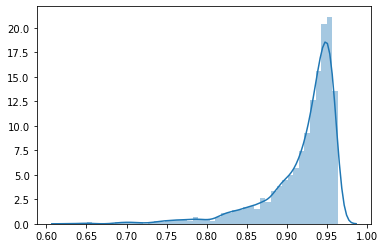

In [43]:
import seaborn as sns

def convert_proba_to_class(probability, thereshold = 0.8):
    return np.where(probability < thereshold, 1, 0)[:,0]

sns.distplot(LGBM_optuna_predicted_test[:, 0])

In [68]:
roc_auc_score(train_target, LGBM_predicted_train[:, 1])

0.9422082458072838

In [69]:
roc_auc_score(test_target, LGBM_predicted_test[:, 1])

0.7371093967840877

In [65]:
roc_auc_score(train_target, LGBM_optuna_predicted_train[:, 1])

0.8151419649629373

In [66]:
roc_auc_score(test_target, LGBM_optuna_predicted_test[:, 1])

0.7434129565944791

In [70]:
LGBM_predicted_train = LGBM_predicted_train[:, 1]
LGBM_predicted_test = LGBM_predicted_test[:, 1]
LGBM_optuna_predicted_train = LGBM_optuna_predicted_train[:, 1]
LGBM_optuna_predicted_test = LGBM_optuna_predicted_test[:, 1]

In [71]:
first_level_output = pd.DataFrame(data=np.array([LGBM_predicted_train, LGBM_optuna_predicted_train]).reshape(len(LGBM_predicted_train), 2), columns=['LGBM', 'LGBM_optuna'])
first_level_output = first_level_output.join(train_full_features.reset_index(drop=True))
first_level_output

,LGBM,LGBM_optuna,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,0.240507,0.035132,445173,0,0,0,1,0,162000.0,619254.0,...,0.0,0.0,0.0,0.0,4.0,-12299.0,-1711.0,1,NaN,0
1,0.028967,0.032600,120419,0,0,0,1,1,202500.0,805536.0,...,0.0,0.0,0.0,0.0,2.0,-19199.0,-4915.0,1,NaN,0
2,0.046010,0.041344,266087,0,0,1,1,0,157500.0,505332.0,...,0.0,0.0,0.0,0.0,1.0,-19446.0,-2813.0,1,NaN,0
3,0.050226,0.043829,200021,0,0,0,1,2,202500.0,260640.0,...,0.0,1.0,0.0,0.0,2.0,-11454.0,-3804.0,1,NaN,0
4,0.067662,0.043467,120701,0,0,0,1,0,54000.0,269550.0,...,NaN,NaN,NaN,NaN,NaN,-19382.0,-1702.0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.086811,0.072566,234579,0,0,0,1,0,162000.0,891072.0,...,NaN,NaN,NaN,NaN,NaN,-23418.0,-730.0,1,NaN,0
7996,0.073260,0.078353,418107,0,0,1,1,0,180000.0,243000.0,...,0.0,0.0,1.0,0.0,4.0,-16790.0,-8458.0,1,NaN,0
7997,0.086404,0.071763,296083,0,1,1,1,0,247500.0,360000.0,...,0.0,0.0,2.0,0.0,3.0,-19193.0,-1856.0,1,NaN,0
7998,0.072849,0.083652,103189,0,1,0,1,0,225000.0,277969.5,...,0.0,1.0,1.0,0.0,2.0,-15925.0,-1194.0,1,NaN,0


In [72]:
first_level_output_test = pd.DataFrame(data=np.array([LGBM_predicted_test, LGBM_optuna_predicted_test]).reshape(len(LGBM_predicted_test), 2), columns=['LGBM_test', 'LGBM_optuna_test'])
first_level_output_test = first_level_output_test.join(test_full_features.reset_index(drop=True))
first_level_output_test

,LGBM_test,LGBM_optuna_test,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BIRTH_DATE,EMP_DATE,constant,allnan,report_dt
0,0.049671,0.088356,220929,0,1,0,1,1,181084.5,1350000.0,...,0.0,0.0,0.0,0.0,2.0,-9993.0,-1087.0,1,NaN,0
1,0.035772,0.035513,200351,0,1,0,1,1,270000.0,1563840.0,...,0.0,0.0,1.0,0.0,1.0,-11812.0,-1106.0,1,NaN,0
2,0.033186,0.058840,198362,0,0,0,0,0,157500.0,1303812.0,...,NaN,NaN,NaN,NaN,NaN,-22647.0,-730.0,1,NaN,0
3,0.090024,0.056043,391215,0,0,0,1,0,180000.0,364896.0,...,0.0,0.0,0.0,2.0,3.0,-19471.0,-2032.0,1,NaN,0
4,0.100214,0.037846,141764,0,1,0,1,0,202500.0,1293502.5,...,0.0,0.0,0.0,1.0,2.0,-16047.0,-4234.0,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.076513,0.072500,233950,1,0,0,1,0,135000.0,270000.0,...,0.0,0.0,0.0,0.0,0.0,-12213.0,-2521.0,1,NaN,0
1996,0.136966,0.093184,156548,0,0,0,1,0,157500.0,254700.0,...,0.0,0.0,0.0,2.0,0.0,-25020.0,-730.0,1,NaN,0
1997,0.074572,0.086018,259136,0,0,0,1,0,180000.0,711612.0,...,0.0,1.0,2.0,0.0,3.0,-17186.0,-3575.0,1,NaN,0
1998,0.073347,0.075465,198267,0,0,0,1,0,112500.0,490495.5,...,0.0,0.0,0.0,0.0,0.0,-20786.0,-2569.0,1,NaN,0


#### Second Level

In [73]:
lgbc=LGBMClassifier(**default_params)
lgbc.fit(first_level_output, train_target, eval_set=(first_level_output_test, test_target), eval_metric = 'auc')
predicted_train = lgbc.predict_proba(first_level_output)
predicted_test = lgbc.predict_proba(first_level_output_test)

/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/magleb/.local/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.64372	valid_0's binary_logloss: 0.260236
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.67394	valid_0's binary_logloss: 0.259874
[3]	valid_0's auc: 0.684199	valid_0's binary_logloss: 0.259358
[4]	valid_0's auc: 0.695009	valid_0's binary_logloss: 0.258989
[5]	valid_0's auc: 0.717715	valid_0's binary_logloss: 0.258573
[6]	valid_0's auc: 0.713155	valid_0's binary_logloss: 0.258212
[7]	valid_0's auc: 0.721058	valid_0's binary_logloss: 0.257936
[8]	valid_0's auc: 0.721723	valid_0's binary_logloss: 0.257783
[9]	valid_0's auc: 0.721463	valid_0's binary_logloss: 0.257308
[10]	valid_0's auc: 0.724117	valid_0's binary_logloss: 0.257034
[11]	valid_0's auc: 0.722959	valid_0's binary_logloss: 0.256768
[12]	valid_0's auc: 0.721563	valid_0's binary_logloss: 0.256516
[13]	valid_0's auc: 0.720476	valid_0's binary_logloss: 0.256243
[14]	valid_0's auc: 0.719446	valid_0's binary_logloss: 0.255849
[15]	valid_0's auc: 0.721496	valid_0's binary_logloss

In [74]:
roc_auc_score(test_target.values, predicted_test[:, 1])

0.7409684914954923

In [75]:
roc_auc_score(train_target.values, predicted_train[:, 1])

0.9010306218366775